# Introduction: Business Problem

If someone is looking to open a restaurant, where would you recommend that they open it and what kind of restaurant would it be? Which Neighborhood and should it be a cafe or fast food restaurant or a bar?
This would help aspiring restaurant/Cafe/Fast food joint owners decide in which neighborhood can they set up shop and would their business be unique enough to thrive in the locality. The recommendation would be made by analysis of the neighborhoods and allow the owners to make a well recommended and smart choice.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


# Data


I will use the new york neighborhood data for neighborhoods. And by using the foursquare API ,recommend neighborhoods with the least amount of restaurants and the type of restaurants that might be unique in the area.

In [2]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [3]:
neighborhoods_data = newyork_data['features']

In [4]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [5]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [6]:
neighborhoods.tail()

Borough  Neighborhood   Latitude  Longitude
301      Manhattan  Hudson Yards  40.756658 -74.000111
302         Queens       Hammels  40.587338 -73.805530
303         Queens     Bayswater  40.611322 -73.765968
304         Queens  Queensbridge  40.756091 -73.945631
305  Staten Island     Fox Hills  40.617311 -74.081740

#### Get the coordinates for new york city

In [7]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [8]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [9]:
neighborhoods.drop(['Borough'],axis=1,inplace=True)

<!-- CLIENT_ID = 'SJVNROHFKAQ0CZ5ULIM0V5K5IXUPI2UV1FARMVENUHS3HB4F' # your Foursquare ID
CLIENT_SECRET = 'W1H0JXEDQWHBWX1ZZYT2IXCRTWLGPSNQ2NOGQ5IA4ZKCQKEU' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30 -->

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&categoryId={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            '4d4b7105d754a06374d81259',# to specify restaurants
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)



In [14]:
new_york_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [15]:
print(new_york_venues.shape)
new_york_venues.head()

(5380, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894705              -73.847201   
1    Wakefield              40.894705              -73.847201   
2    Wakefield              40.894705              -73.847201   
3    Wakefield              40.894705              -73.847201   
4    Wakefield              40.894705              -73.847201   

                                     Venue  Venue Latitude  Venue Longitude  \
0                                  Dunkin'       40.890459       -73.849089   
1  Cooler Runnings Jamaican Restaurant Inc       40.898083       -73.850259   
2                                   SUBWAY       40.890468       -73.849152   
3                              Pitman Deli       40.894149       -73.845748   
4                             Central Deli       40.896728       -73.844387   

         Venue Category  
0            Donut Shop  
1  Caribbean Restaurant  
2        Sandwich Place  
3                  Food  
4         Deli / Bodega

In [16]:
map_restaurant = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(new_york_venues['Venue Latitude'], new_york_venues['Venue Longitude'], new_york_venues['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_restaurant)  
    
map_restaurant

#### one hot encoding to get different categorical variables as columns

In [17]:
# one hot encoding to get different categorical variables as columns
new_york_onehot = pd.get_dummies(new_york_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
new_york_onehot['Neighborhood'] = new_york_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [new_york_onehot.columns[-1]] + list(new_york_onehot.columns[:-1])
new_york_onehot = new_york_onehot[fixed_columns]

new_york_onehot.head()

Neighborhood  Afghan Restaurant  African Restaurant  American Restaurant  \
0    Wakefield                  0                   0                    0   
1    Wakefield                  0                   0                    0   
2    Wakefield                  0                   0                    0   
3    Wakefield                  0                   0                    0   
4    Wakefield                  0                   0                    0   

   Arepa Restaurant  Argentinian Restaurant  Asian Restaurant  \
0                 0                       0                 0   
1                 0                       0                 0   
2                 0                       0                 0   
3                 0                       0                 0   
4                 0                       0                 0   

   Australian Restaurant  Austrian Restaurant  BBQ Joint  Bagel Shop  Bakery  \
0                      0                    0          0           0       0   
1                      0                    0          0           0       0   
2                      0                    0          0           0       0   
3                      0                    0          0           0       0   
4                      0                    0          0           0       0   

   Bistro  Brazilian Restaurant  Breakfast Spot  Buffet  Burger Joint  \
0       0                     0               0       0             0   
1       0                     0               0       0             0   
2       0                     0               0       0             0   
3       0                     0               0       0             0   
4       0                     0               0       0             0   

   Burrito Place  Cafeteria  Café  Cajun / Creole Restaurant  \
0              0          0     0                          0   
1              0          0     0                          0   
2              0          0     0                          0   
3              0          0     0                          0   
4              0          0     0                          0   

   Cantonese Restaurant  Caribbean Restaurant  Caucasian Restaurant  \
0                     0                     0                     0   
1                     0                     1                     0   
2                     0                     0                     0   
3                     0                     0                     0   
4                     0                     0                     0   

   Chinese Restaurant  Colombian Restaurant  Comfort Food Restaurant  \
0                   0                     0                        0   
1                   0                     0                        0   
2                   0                     0                        0   
3                   0                     0                        0   
4                   0                     0                        0   

   Creperie  Cuban Restaurant  Czech Restaurant  Deli / Bodega  \
0         0                 0                 0              0   
1         0                 0                 0              0   
2         0                 0                 0              0   
3         0                 0                 0              0   
4         0                 0                 0              1   

   Dim Sum Restaurant  Diner  Donut Shop  Dosa Place  Dumpling Restaurant  \
0                   0      0           1           0                    0   
1                   0      0           0           0                    0   
2                   0      0           0           0                    0   
3                   0      0           0           0                    0   
4                   0      0           0           0                    0   

   Eastern European Restaurant  Egyptian Restaurant  Empanada Restaurant  \
0                            0           

In [18]:
new_york_onehot.shape

(5380, 123)

In [19]:
new_york_grouped = new_york_onehot.groupby('Neighborhood').mean().reset_index()
new_york_grouped.head()

Neighborhood  Afghan Restaurant  African Restaurant  American Restaurant  \
0       Allerton                0.0                 0.0             0.043478   
1       Annadale                0.0                 0.0             0.200000   
2  Arden Heights                0.0                 0.0             0.000000   
3      Arlington                0.0                 0.0             0.250000   
4       Arrochar                0.0                 0.0             0.000000   

   Arepa Restaurant  Argentinian Restaurant  Asian Restaurant  \
0               0.0                     0.0               0.0   
1               0.0                     0.0               0.0   
2               0.0                     0.0               0.0   
3               0.0                     0.0               0.0   
4               0.0                     0.0               0.0   

   Australian Restaurant  Austrian Restaurant  BBQ Joint  Bagel Shop  \
0                    0.0                  0.0        0.0    0.000000   
1                    0.0                  0.0        0.0    0.000000   
2                    0.0                  0.0        0.0    0.000000   
3                    0.0                  0.0        0.0    0.000000   
4                    0.0                  0.0        0.0    0.142857   

     Bakery  Bistro  Brazilian Restaurant  Breakfast Spot  Buffet  \
0  0.130435     0.0                   0.0        0.043478     0.0   
1  0.133333     0.0                   0.0        0.000000     0.0   
2  0.000000     0.0                   0.0        0.000000     0.0   
3  0.000000     0.0                   0.0        0.000000     0.0   
4  0.000000     0.0                   0.0        0.000000     0.0   

   Burger Joint  Burrito Place  Cafeteria  Café  Cajun / Creole Restaurant  \
0           0.0            0.0        0.0   0.0                        0.0   
1           0.0            0.0        0.0   0.0                        0.0   
2           0.0            0.0        0.0   0.0                        0.0   
3           0.0            0.0        0.0   0.0                        0.0   
4           0.0            0.0        0.0   0.0                        0.0   

   Cantonese Restaurant  Caribbean Restaurant  Caucasian Restaurant  \
0                   0.0                   0.0                   0.0   
1                   0.0                   0.0                   0.0   
2                   0.0                   0.0                   0.0   
3                   0.0                   0.0                   0.0   
4                   0.0                   0.0                   0.0   

   Chinese Restaurant  Colombian Restaurant  Comfort Food Restaurant  \
0            0.086957                   0.0                      0.0   
1            0.000000                   0.0                      0.0   
2            0.000000                   0.0                      0.0   
3            0.000000                   0.0                      0.0   
4            0.000000                   0.0                      0.0   

   Creperie  Cuban Restaurant  Czech Restaurant  Deli / Bodega  \
0       0.0               0.0               0.0       0.173913   
1       0.0               0.0               0.0       0.066667   
2       0.0               0.0               0.0       0.500000   
3       0.0               0.0               0.0       0.250000   
4       0.0               0.0               0.0       0.142857   

   Dim Sum Restaurant     Diner  Donut Shop  Dosa Place  Dumpling Restaurant  \
0                 0.0  0.000000    0.043478         0.0                  0.0   
1                 0.0  0.066667    0.000000         0.0                  0.0   
2                 0.0  0.000000    0.000000         0.0                  0.0   
3                 0.0  0.000000    0.000000         0.0                  0.0   
4                 0.0  0.000000    0.000000         0.0                  0.0   

   Eastern European Restaurant  Egyptian Restaurant  Empanada Restaurant  \
0

In [20]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [21]:
num_top_venues = 5
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = new_york_grouped['Neighborhood']

for ind in np.arange(new_york_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(new_york_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0       Allerton           Pizza Place         Deli / Bodega   
1       Annadale           Pizza Place   American Restaurant   
2  Arden Heights         Deli / Bodega           Pizza Place   
3      Arlington         Deli / Bodega   American Restaurant   
4       Arrochar         Deli / Bodega            Bagel Shop   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
0                Bakery    Chinese Restaurant   Fried Chicken Joint  
1                Bakery         Deli / Bodega                 Diner  
2    Dim Sum Restaurant            Donut Shop            Dosa Place  
3   Peruvian Restaurant  Fast Food Restaurant                  Food  
4           Pizza Place    Italian Restaurant        Sandwich Place

### using Kmeans to cluster similar neighborhoods together

In [22]:
kclusters = 5

new_york_grouped_clustering = new_york_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(new_york_grouped_clustering)

In [23]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

new_york_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
new_york_merged = new_york_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

new_york_merged.dropna(inplace=True)
new_york_merged.head()

Neighborhood   Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
0    Wakefield  40.894705 -73.847201             3.0         Deli / Bodega   
1   Co-op City  40.874294 -73.829939             3.0           Pizza Place   
2  Eastchester  40.887556 -73.827806             1.0  Caribbean Restaurant   
4    Riverdale  40.890834 -73.912585             0.0            Food Truck   
5  Kingsbridge  40.881687 -73.902818             0.0           Pizza Place   

  2nd Most Common Venue      3rd Most Common Venue 4th Most Common Venue  \
0           Pizza Place                 Donut Shop        Sandwich Place   
1            Restaurant       Fast Food Restaurant            Bagel Shop   
2         Deli / Bodega                      Diner                Bakery   
4           Wings Joint                       Food            Donut Shop   
5        Sandwich Place  Latin American Restaurant    Mexican Restaurant   

  5th Most Common Venue  
0  Caribbean Restaurant  
1    Chinese Restaurant  
2            Donut Shop  
4            Dosa Place  
5   Fried Chicken Joint

In [24]:
clusterdata = pd.merge(new_york_onehot.groupby('Neighborhood').sum(),new_york_merged[['Neighborhood','Cluster Labels']],left_on='Neighborhood', right_on='Neighborhood',how='inner')
clusterdata = clusterdata.iloc[:,1:].groupby('Cluster Labels').sum().transpose()
clusterdata.head()

Cluster Labels            0.0  1.0  2.0   3.0  4.0
Afghan Restaurant         2.0  0.0  0.0   1.0  0.0
African Restaurant        3.0  0.0  0.0   4.0  0.0
American Restaurant     133.0  0.0  0.0  43.0  0.0
Arepa Restaurant          5.0  0.0  0.0   2.0  0.0
Argentinian Restaurant    7.0  0.0  0.0   0.0  0.0

In [25]:
import seaborn as sns

## plotting graphs for better visualizations of the data obtained

[Text(0, 0, 'Afghan Restaurant'),
 Text(0, 0, 'African Restaurant'),
 Text(0, 0, 'American Restaurant'),
 Text(0, 0, 'Arepa Restaurant'),
 Text(0, 0, 'Argentinian Restaurant'),
 Text(0, 0, 'Asian Restaurant'),
 Text(0, 0, 'Australian Restaurant'),
 Text(0, 0, 'Austrian Restaurant'),
 Text(0, 0, 'BBQ Joint'),
 Text(0, 0, 'Bagel Shop'),
 Text(0, 0, 'Bakery'),
 Text(0, 0, 'Bistro'),
 Text(0, 0, 'Brazilian Restaurant'),
 Text(0, 0, 'Breakfast Spot'),
 Text(0, 0, 'Buffet'),
 Text(0, 0, 'Burger Joint'),
 Text(0, 0, 'Burrito Place'),
 Text(0, 0, 'Cafeteria'),
 Text(0, 0, 'Café'),
 Text(0, 0, 'Cajun / Creole Restaurant'),
 Text(0, 0, 'Cantonese Restaurant'),
 Text(0, 0, 'Caribbean Restaurant'),
 Text(0, 0, 'Caucasian Restaurant'),
 Text(0, 0, 'Chinese Restaurant'),
 Text(0, 0, 'Colombian Restaurant'),
 Text(0, 0, 'Comfort Food Restaurant'),
 Text(0, 0, 'Creperie'),
 Text(0, 0, 'Cuban Restaurant'),
 Text(0, 0, 'Czech Restaurant'),
 Text(0, 0, 'Deli / Bodega'),
 Text(0, 0, 'Dim Sum Restaurant'),

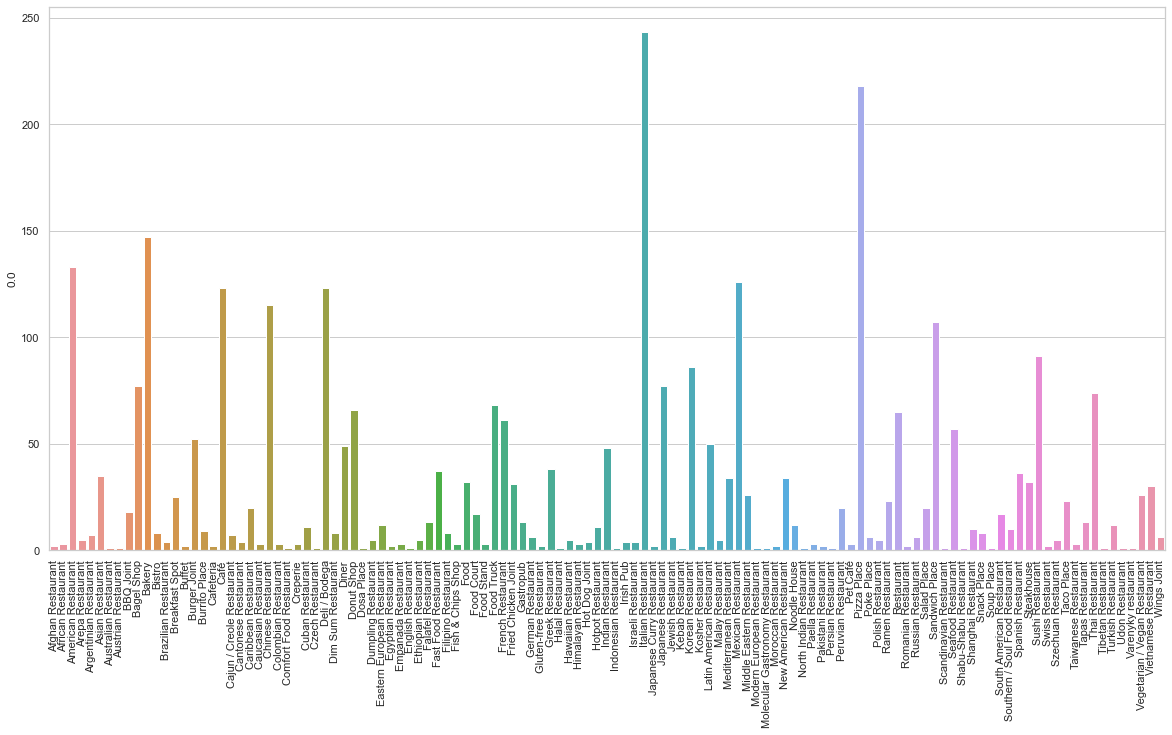

In [26]:
sns.set(style="whitegrid",rc={'figure.figsize':(20,10)})
df = clusterdata[[0]].drop(clusterdata[[0]][clusterdata[0]==0].index)
chart = sns.barplot(x=df.index, y=0, data=df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

[Text(0, 0, 'Asian Restaurant'),
 Text(0, 0, 'Bakery'),
 Text(0, 0, 'Breakfast Spot'),
 Text(0, 0, 'Café'),
 Text(0, 0, 'Caribbean Restaurant'),
 Text(0, 0, 'Chinese Restaurant'),
 Text(0, 0, 'Deli / Bodega'),
 Text(0, 0, 'Diner'),
 Text(0, 0, 'Donut Shop'),
 Text(0, 0, 'Fast Food Restaurant'),
 Text(0, 0, 'Food'),
 Text(0, 0, 'Food Truck'),
 Text(0, 0, 'Fried Chicken Joint'),
 Text(0, 0, 'Mexican Restaurant'),
 Text(0, 0, 'Pizza Place'),
 Text(0, 0, 'Restaurant'),
 Text(0, 0, 'Salad Place'),
 Text(0, 0, 'Sandwich Place'),
 Text(0, 0, 'Seafood Restaurant'),
 Text(0, 0, 'Soup Place'),
 Text(0, 0, 'Southern / Soul Food Restaurant'),
 Text(0, 0, 'Thai Restaurant'),
 Text(0, 0, 'Wings Joint')]

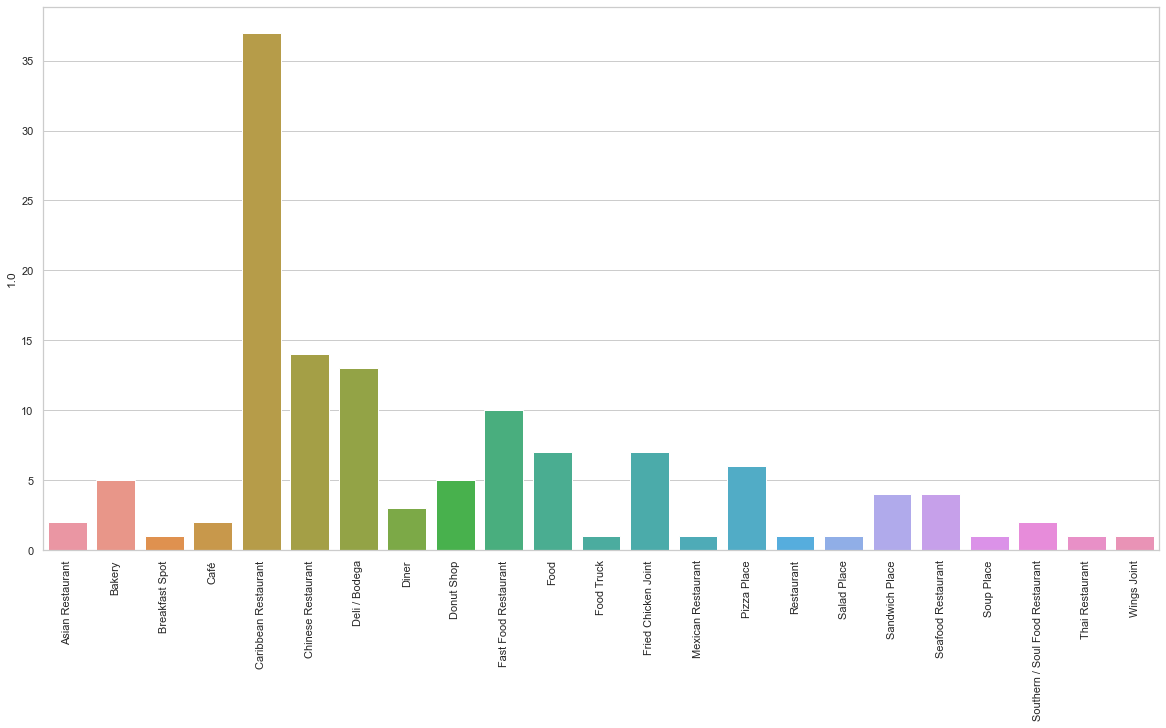

In [27]:
sns.set(style="whitegrid",rc={'figure.figsize':(20,10)})
df = clusterdata[[1]].drop(clusterdata[[1]][clusterdata[1]==0].index)
chart = sns.barplot(x=df.index, y=1, data=df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

[Text(0, 0, 'Asian Restaurant'),
 Text(0, 0, 'BBQ Joint'),
 Text(0, 0, 'Café'),
 Text(0, 0, 'Food'),
 Text(0, 0, 'Pizza Place'),
 Text(0, 0, 'Restaurant'),
 Text(0, 0, 'Spanish Restaurant')]

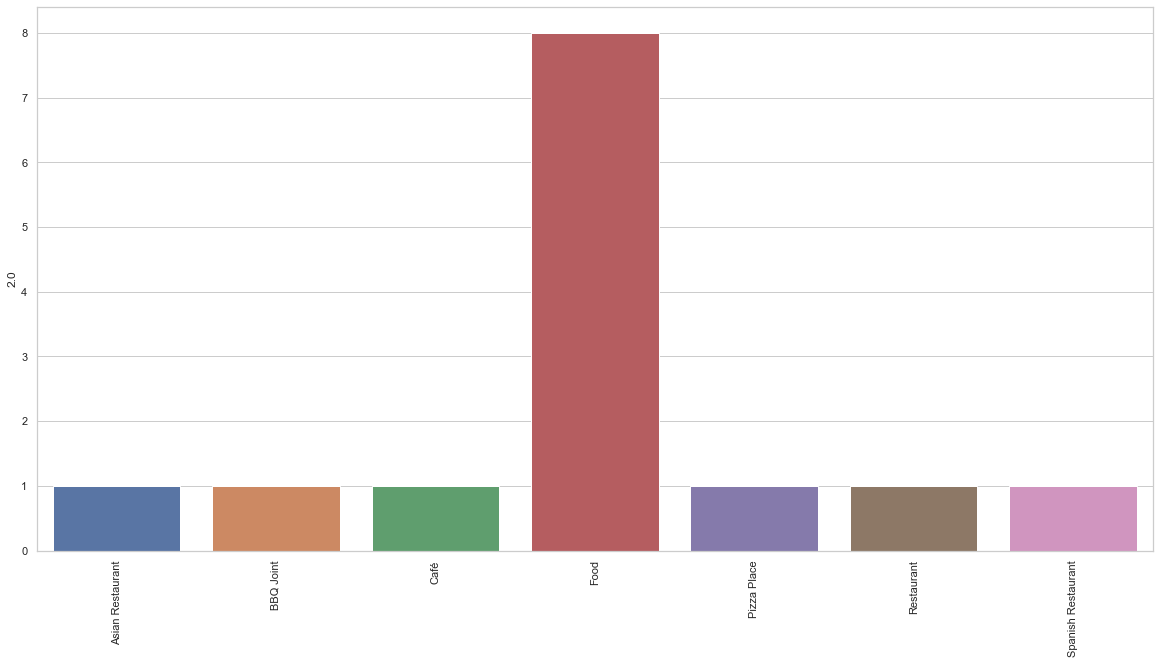

In [28]:
sns.set(style="whitegrid",rc={'figure.figsize':(20,10)})
df = clusterdata[[2]].drop(clusterdata[[2]][clusterdata[2]==0].index)
chart = sns.barplot(x=df.index, y=2, data=df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

[Text(0, 0, 'Afghan Restaurant'),
 Text(0, 0, 'African Restaurant'),
 Text(0, 0, 'American Restaurant'),
 Text(0, 0, 'Arepa Restaurant'),
 Text(0, 0, 'Asian Restaurant'),
 Text(0, 0, 'BBQ Joint'),
 Text(0, 0, 'Bagel Shop'),
 Text(0, 0, 'Bakery'),
 Text(0, 0, 'Bistro'),
 Text(0, 0, 'Breakfast Spot'),
 Text(0, 0, 'Buffet'),
 Text(0, 0, 'Burger Joint'),
 Text(0, 0, 'Burrito Place'),
 Text(0, 0, 'Cafeteria'),
 Text(0, 0, 'Café'),
 Text(0, 0, 'Cajun / Creole Restaurant'),
 Text(0, 0, 'Caribbean Restaurant'),
 Text(0, 0, 'Chinese Restaurant'),
 Text(0, 0, 'Comfort Food Restaurant'),
 Text(0, 0, 'Creperie'),
 Text(0, 0, 'Cuban Restaurant'),
 Text(0, 0, 'Deli / Bodega'),
 Text(0, 0, 'Diner'),
 Text(0, 0, 'Donut Shop'),
 Text(0, 0, 'Dumpling Restaurant'),
 Text(0, 0, 'Eastern European Restaurant'),
 Text(0, 0, 'Empanada Restaurant'),
 Text(0, 0, 'Falafel Restaurant'),
 Text(0, 0, 'Fast Food Restaurant'),
 Text(0, 0, 'Fish & Chips Shop'),
 Text(0, 0, 'Food'),
 Text(0, 0, 'Food Court'),
 Text(0, 

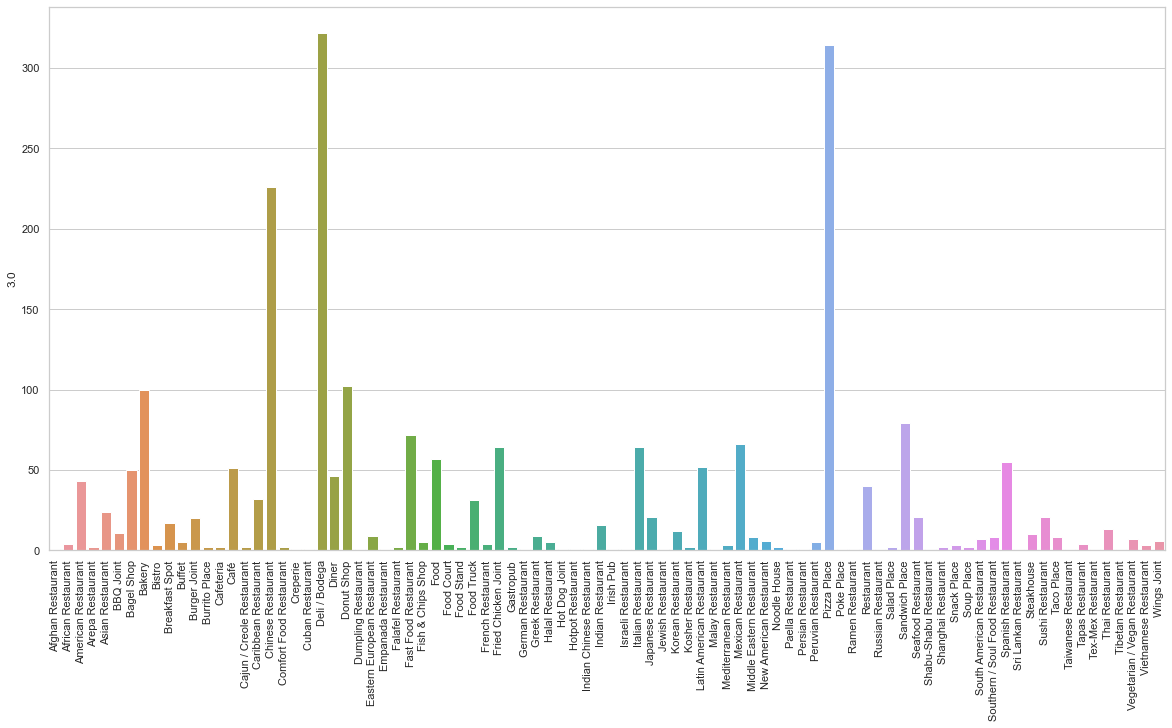

In [29]:
sns.set(style="whitegrid",rc={'figure.figsize':(20,10)})
df = clusterdata[[3]].drop(clusterdata[[3]][clusterdata[3]==0].index)
chart = sns.barplot(x=df.index, y=3, data=df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

[Text(0, 0, 'Deli / Bodega')]

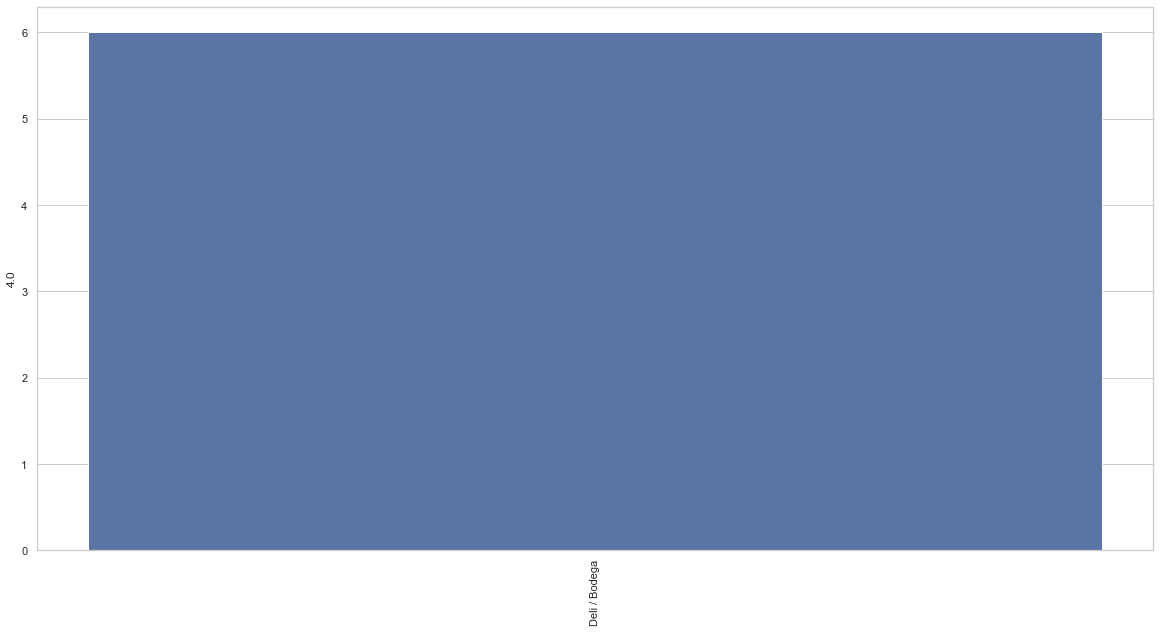

In [30]:
sns.set(style="whitegrid",rc={'figure.figsize':(20,10)})
df = clusterdata[[4]].drop(clusterdata[[4]][clusterdata[4]==0].index)
chart = sns.barplot(x=df.index, y=4, data=df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

# Results and Discussion

The above data analysis was done to help aspiring restaurant owners get their hands on better information for opening a restaurant. The results for the analysis are conveyed with the help of bar graphs. It's clear from the graphs that cluster 4 neighborhoods are much better for opening restaurants because of their low number of categories and restaurants.

In [31]:
new_york_merged.head()

Neighborhood   Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
0    Wakefield  40.894705 -73.847201             3.0         Deli / Bodega   
1   Co-op City  40.874294 -73.829939             3.0           Pizza Place   
2  Eastchester  40.887556 -73.827806             1.0  Caribbean Restaurant   
4    Riverdale  40.890834 -73.912585             0.0            Food Truck   
5  Kingsbridge  40.881687 -73.902818             0.0           Pizza Place   

  2nd Most Common Venue      3rd Most Common Venue 4th Most Common Venue  \
0           Pizza Place                 Donut Shop        Sandwich Place   
1            Restaurant       Fast Food Restaurant            Bagel Shop   
2         Deli / Bodega                      Diner                Bakery   
4           Wings Joint                       Food            Donut Shop   
5        Sandwich Place  Latin American Restaurant    Mexican Restaurant   

  5th Most Common Venue  
0  Caribbean Restaurant  
1    Chinese Restaurant  
2            Donut Shop  
4            Dosa Place  
5   Fried Chicken Joint

In [33]:
new_york_recommended=new_york_merged[new_york_merged['Cluster Labels']==4.0]

In [40]:
map_restaurant = folium.Map(location=[latitude, longitude], zoom_start=10.5)

# add markers to map
for lat, lng, label in zip(new_york_recommended['Latitude'], new_york_recommended['Longitude'],new_york_recommended['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_restaurant)  
    
map_restaurant

## Conclusion

The analysis was successfully completed and suitable recommendation can be obtained from the visualized data.